# Near earth objects

#### https://cneos.jpl.nasa.gov/ca/

In [948]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

### data import, cleaning

In [949]:
df = pd.read_csv("D:\\Github\\Science\\NEO\\cneos_closeapproach_data.csv", sep=",")
df = df.drop(columns=['CA Distance Minimum (LD | au)', 'V relative (km/s)', 'V infinity (km/s)', 'H (mag)', 'Unnamed: 8'])

In [950]:
df.head(2)

,Object,Close-Approach (CA) Date,CA Distance Nominal (LD | au),Diameter
0,99942 Apophis (2004 MN4),2029-Apr-13 21:46 ± < 00:01,0.10 | 0.00025,0.34±0.04 km
1,(2010 RF12),2095-Sep-06 00:06 ± 00:44,0.10 | 0.00026,5.6 m - 12 m


In [951]:
df.dtypes

Object                           object
Close-Approach (CA) Date         object
CA Distance Nominal (LD | au)    object
Diameter                         object
dtype: object

In [952]:
df["LD"] = df["CA Distance Nominal (LD | au)"].str.split(' ', expand = True)[0]

In [953]:
df.head(2)

,Object,Close-Approach (CA) Date,CA Distance Nominal (LD | au),Diameter,LD
0,99942 Apophis (2004 MN4),2029-Apr-13 21:46 ± < 00:01,0.10 | 0.00025,0.34±0.04 km,0.10
1,(2010 RF12),2095-Sep-06 00:06 ± 00:44,0.10 | 0.00026,5.6 m - 12 m,0.10


In [954]:
df["LD"] = pd.to_numeric(df["LD"], errors='coerce')

In [955]:
df.dtypes

Object                            object
Close-Approach (CA) Date          object
CA Distance Nominal (LD | au)     object
Diameter                          object
LD                               float64
dtype: object

In [956]:
df.index = np.arange(1, len(df) + 1 )
df["x_axis"] = df.index
df.head(2)

,Object,Close-Approach (CA) Date,CA Distance Nominal (LD | au),Diameter,LD,x_axis
1,99942 Apophis (2004 MN4),2029-Apr-13 21:46 ± < 00:01,0.10 | 0.00025,0.34±0.04 km,0.1,1
2,(2010 RF12),2095-Sep-06 00:06 ± 00:44,0.10 | 0.00026,5.6 m - 12 m,0.1,2


### calculation

In [957]:
df["distance_km"] = df["LD"]*394_399

In [958]:
df["zero"]=0
df["earth"] = 6_371
df["ISS"] = 6_371+408
df["geostationary"] = 35_786

In [959]:
df = df.loc[df["LD"] < 10]

In [960]:
df.head(2)

,Object,Close-Approach (CA) Date,CA Distance Nominal (LD | au),Diameter,LD,x_axis,distance_km,zero,earth,ISS,geostationary
1,99942 Apophis (2004 MN4),2029-Apr-13 21:46 ± < 00:01,0.10 | 0.00025,0.34±0.04 km,0.1,1,39439.9,0,6371,6779,35786
2,(2010 RF12),2095-Sep-06 00:06 ± 00:44,0.10 | 0.00026,5.6 m - 12 m,0.1,2,39439.9,0,6371,6779,35786


### size

In [961]:
# km oder m auslesen
df["size_unit"] = df["Diameter"].str[-2:]


# Teile alle Durchmesser mit ±
df["d1"] = df["Diameter"].str.split('±', expand = True)[0]
df["d1"] = pd.to_numeric(df["d1"], errors='coerce')

# definiere size factor = 1000, ausser bei " m" = 1
df["size_factor"] = 1_000
df.loc[df["size_unit"] == " m", "size_factor"] = 1
df.head(3)

,Object,Close-Approach (CA) Date,CA Distance Nominal (LD | au),Diameter,LD,x_axis,distance_km,zero,earth,ISS,geostationary,size_unit,d1,size_factor
1,99942 Apophis (2004 MN4),2029-Apr-13 21:46 ± < 00:01,0.10 | 0.00025,0.34±0.04 km,0.10,1,39439.90,0,6371,6779,35786,km,0.34,1000
2,(2010 RF12),2095-Sep-06 00:06 ± 00:44,0.10 | 0.00026,5.6 m - 12 m,0.10,2,39439.90,0,6371,6779,35786,m,NaN,1
3,(2007 UW1),2129-Oct-19 03:09 ± 01:30,0.22 | 0.00056,77 m - 170 m,0.22,3,86767.78,0,6371,6779,35786,m,NaN,1


In [962]:
# mittlerer Durchmesser ermitteln

df["d_von"] = df["Diameter"].str.split(' ', expand = True)[0]
df["d_von"] = pd.to_numeric(df["d_von"], errors='coerce')

df["d_bis"] = df["Diameter"].str.split('- ', expand = True)[1]
df["d_bis"] = df["d_bis"].str.split(' m', expand = True)[0]
df["d_bis"] = pd.to_numeric(df["d_bis"], errors='coerce')

df["mittel1"] = df["d1"] * df["size_factor"]
df["mittel1"] = df["mittel1"].fillna(1)

df["mittel2"] = (df["d_von"]+df["d_bis"]) *(1/2) * df["size_factor"]
df["mittel2"] = df["mittel2"].fillna(1)

df["diameter_mean"] = df["mittel1"] * df["mittel2"]

df = df.drop(columns=['d1', 
                      'd_von', 
                      'd_bis', 
                      'mittel1', 
                      'mittel2', 
                      'size_factor', 
                      'CA Distance Nominal (LD | au)', 
                      'size_unit'])

df.head(3)

,Object,Close-Approach (CA) Date,Diameter,LD,x_axis,distance_km,zero,earth,ISS,geostationary,diameter_mean
1,99942 Apophis (2004 MN4),2029-Apr-13 21:46 ± < 00:01,0.34±0.04 km,0.10,1,39439.90,0,6371,6779,35786,340.0
2,(2010 RF12),2095-Sep-06 00:06 ± 00:44,5.6 m - 12 m,0.10,2,39439.90,0,6371,6779,35786,8.8
3,(2007 UW1),2129-Oct-19 03:09 ± 01:30,77 m - 170 m,0.22,3,86767.78,0,6371,6779,35786,123.5


In [963]:
# Liste erstellen für die Größen

In [964]:
max_größe = df["diameter_mean"].max()
max_größe

6250.0

In [965]:
df["marker_size"] = 300 * (df["diameter_mean"] / max_größe)



# definiere size factor = 1000, ausser bei " m" = 1
# df["marker_size2"] = 15
# df.loc[df["marker_size"] > 15, "marker_size2"] = 200 * (df["diameter_mean"] / max_größe)



df.head(4)

,Object,Close-Approach (CA) Date,Diameter,LD,x_axis,distance_km,zero,earth,ISS,geostationary,diameter_mean,marker_size
1,99942 Apophis (2004 MN4),2029-Apr-13 21:46 ± < 00:01,0.34±0.04 km,0.10,1,39439.90,0,6371,6779,35786,340.0,16.3200
2,(2010 RF12),2095-Sep-06 00:06 ± 00:44,5.6 m - 12 m,0.10,2,39439.90,0,6371,6779,35786,8.8,0.4224
3,(2007 UW1),2129-Oct-19 03:09 ± 01:30,77 m - 170 m,0.22,3,86767.78,0,6371,6779,35786,123.5,5.9280
4,(2007 UD6),2048-Oct-18 02:48 ± 2_09:26,5.8 m - 13 m,0.22,4,86767.78,0,6371,6779,35786,9.4,0.4512


### visualize

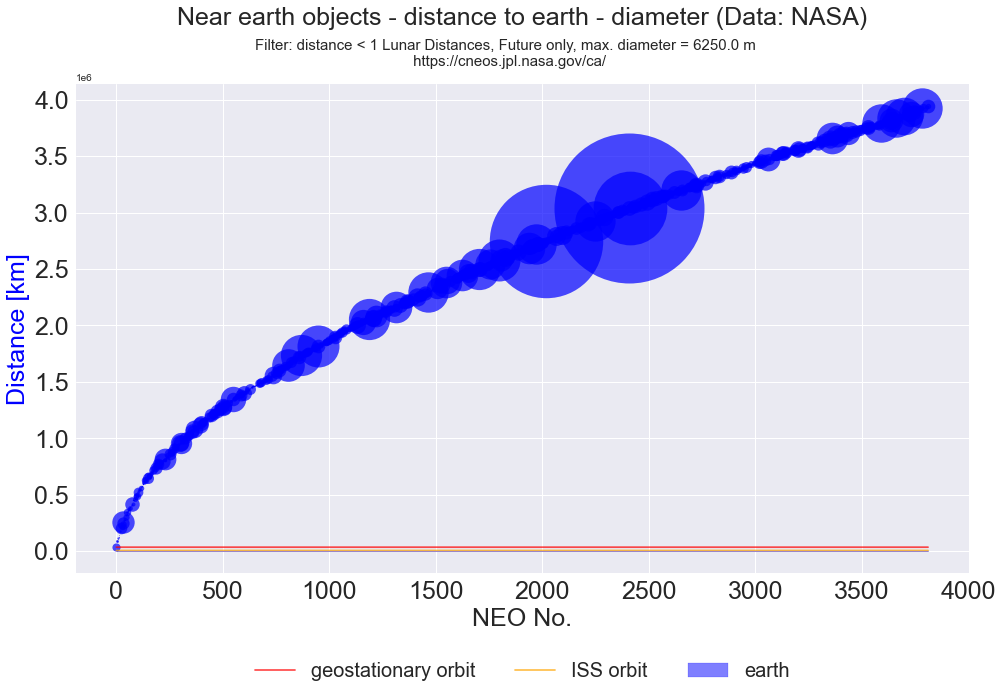

In [966]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(16, 9))
# plt.plot(df["distance_km"],color="blue", alpha=0.7, marker=".", markersize=marker_size_list1,
#          linestyle="", label="Near earth object")


[ax.plot(row['x_axis'], row['distance_km'], '.', markersize=row['marker_size'], alpha=0.7, color = "blue", label = "") for idx, row in df.iterrows()]


# plt.plot(df["zero"],color="brown", alpha=0.7, marker="", markersize=10,
#          linestyle="-", label="")

# plt.plot(df["earth"],color="brown", alpha=0.7, marker="", markersize=10,
#          linestyle="-", label="")

plt.fill_between(df.x_axis, df['earth'], df['zero'], color='blue', alpha=0.5,
                 label=f'earth')


plt.plot(df["geostationary"],color="red", alpha=0.7, marker="", markersize=10,
         linestyle="-", label="geostationary orbit")

plt.plot(df["ISS"],color="orange", alpha=0.7, marker="", markersize=10,
         linestyle="-", label="ISS orbit")



ax.set_xlabel("NEO No.", fontsize=25)
ax.set_ylabel("Distance [km]", color="blue", fontsize=25)

ax.tick_params(labelsize=25)

plt.legend(loc='center',
           bbox_to_anchor=(0.5, -0.2),
           fancybox=True,
           shadow=True,
           ncol=4,
           fontsize=20)

plt.title(f' Near earth objects - distance to earth - diameter (Data: NASA) \n\n', fontsize=25)
plt.suptitle(f'Filter: distance < 1 Lunar Distances, Future only, max. diameter = {max_größe} m \n https://cneos.jpl.nasa.gov/ca/', fontsize=15, y=0.95)

plt.savefig("D:\\Github\\Science\\NEO\\NEO_ohne cap.png", dpi=300, bbox_inches='tight')



In [967]:
df.head(1)

,Object,Close-Approach (CA) Date,Diameter,LD,x_axis,distance_km,zero,earth,ISS,geostationary,diameter_mean,marker_size
1,99942 Apophis (2004 MN4),2029-Apr-13 21:46 ± < 00:01,0.34±0.04 km,0.1,1,39439.9,0,6371,6779,35786,340.0,16.32


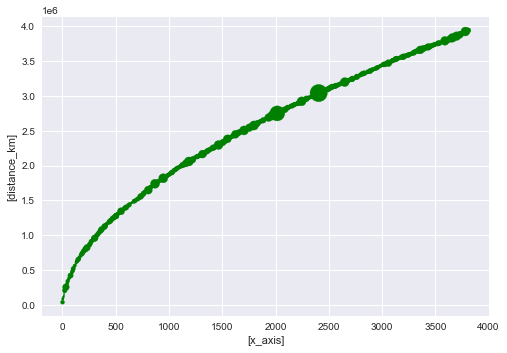

In [968]:
df.plot.scatter(x=['x_axis'], y=['distance_km'], s=df['marker_size'], c='g')
